🎓 Capstone Project 1 — California Housing Prediction

1. Project Overview
1.1 Overview and Problem Statement

## Import the required packages

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


## Load Data

In [61]:
df = pd.read_csv('housing.csv')
print(df.head())
print(df.shape)


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
(20640, 10)


## 2. Data Preparation and Exploratory Data Analysis (EDA)

In [62]:
# 2. Data Preparation and Exploratory Data Analysis (EDA)

# Show the columns
print(df.columns)

# ocean_proximity is categorical variable
to_categorical = ['ocean_proximity']
df[to_categorical] = df[to_categorical].astype('category')

# housing_median_age and total_rooms are integer variables
to_integer = ['housing_median_age', 'total_rooms', 'households', 'population']
df[to_integer] = df[to_integer].astype('int64')

numerical_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

print(df.info())
print(df.describe())

# Locate NaN values in each column
nan_counts = df.isna().sum()
print("Number of NaN values in each column:")
print(nan_counts)




Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  int64   
 3   total_rooms         20640 non-null  int64   
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  int64   
 6   households          20640 non-null  int64   
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(5), int64(4)
memory usage: 1.4 MB
None
          lon

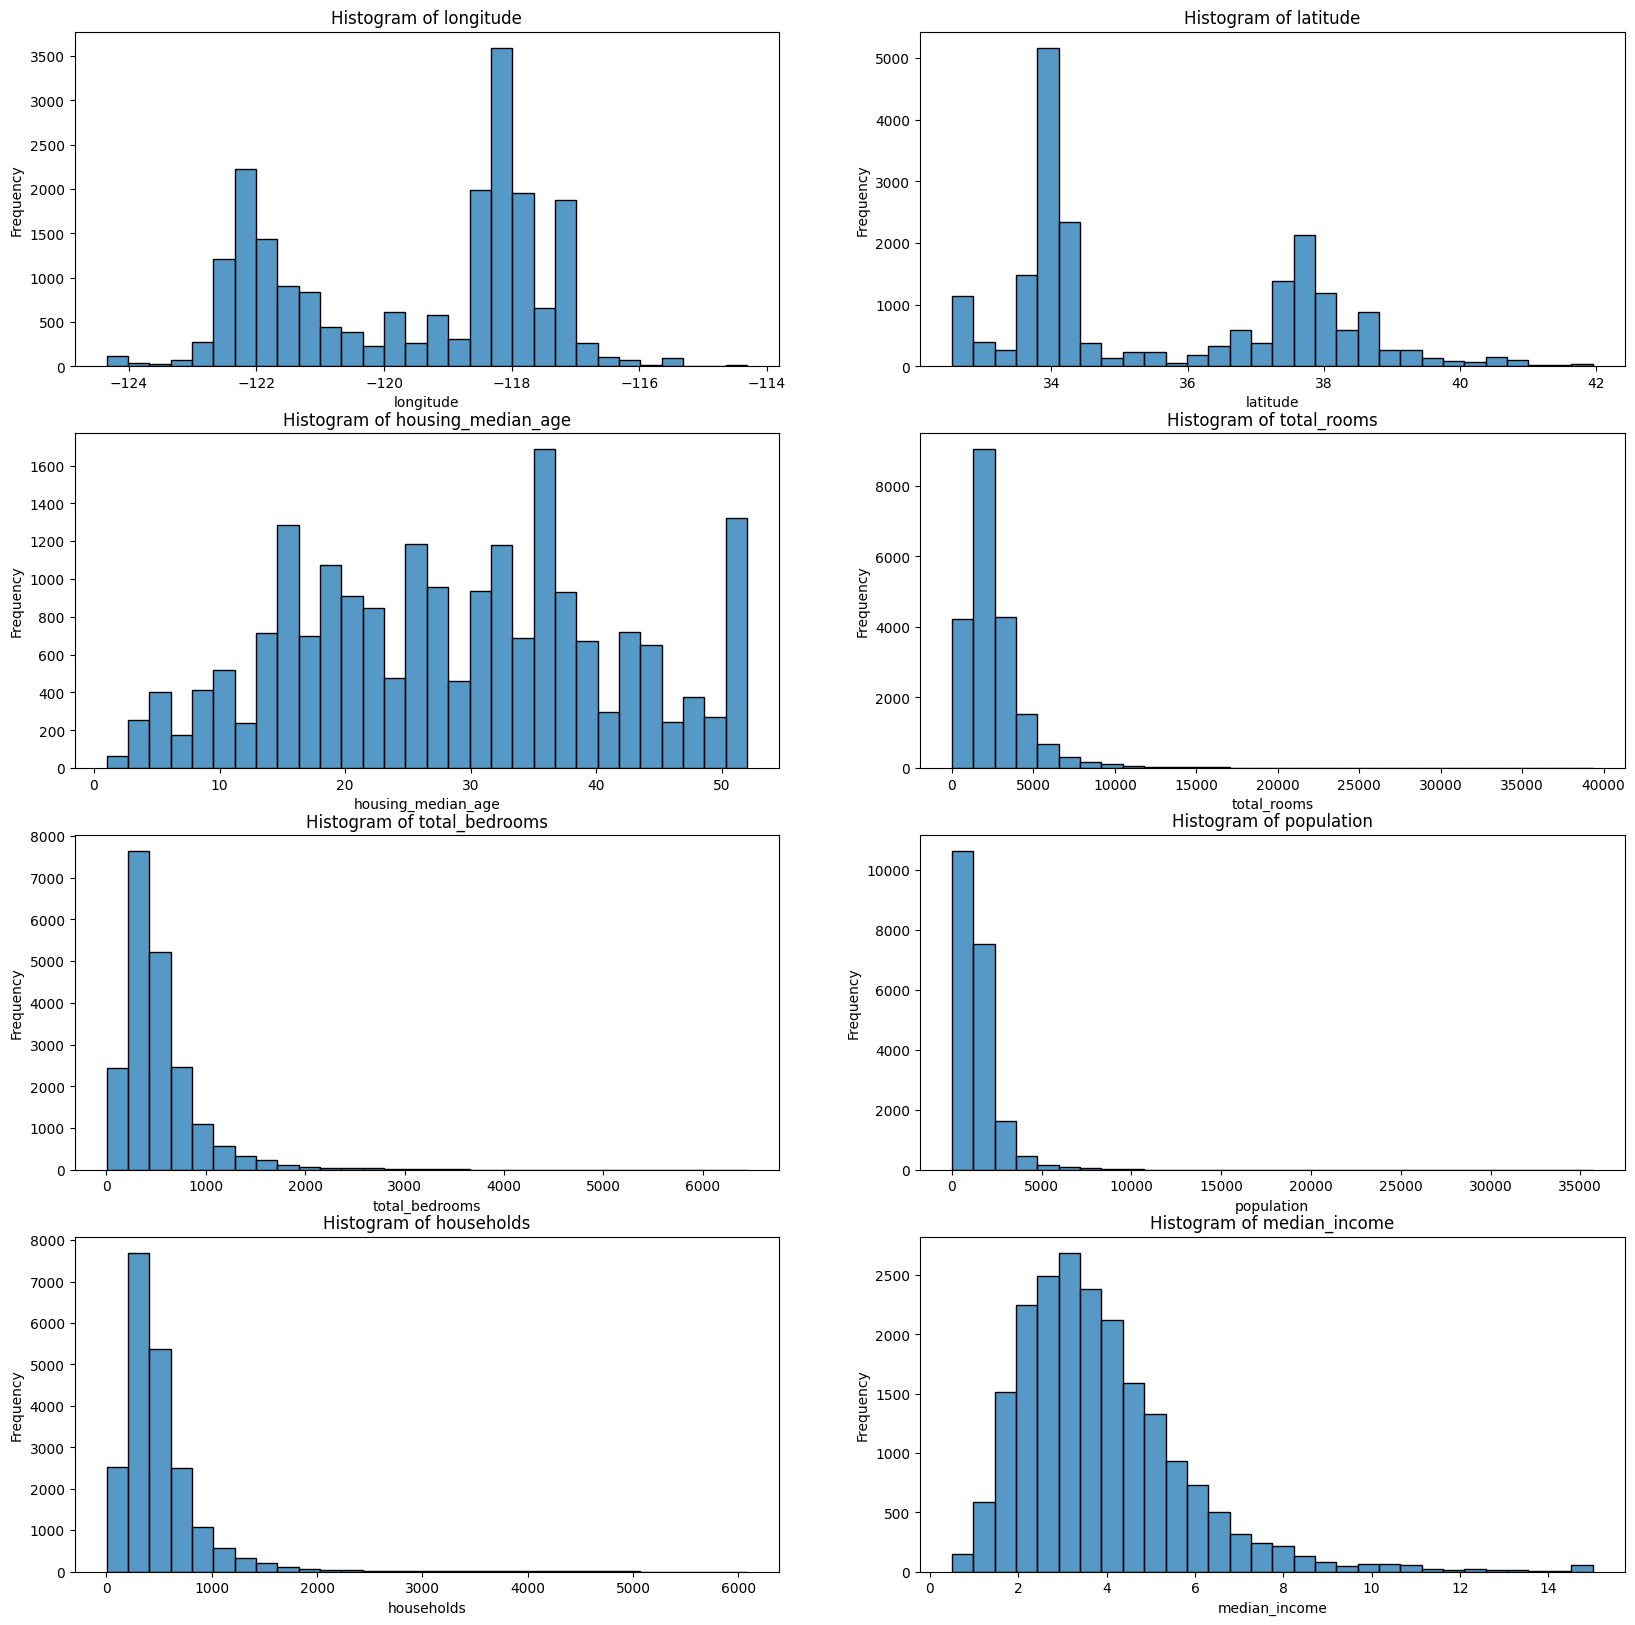

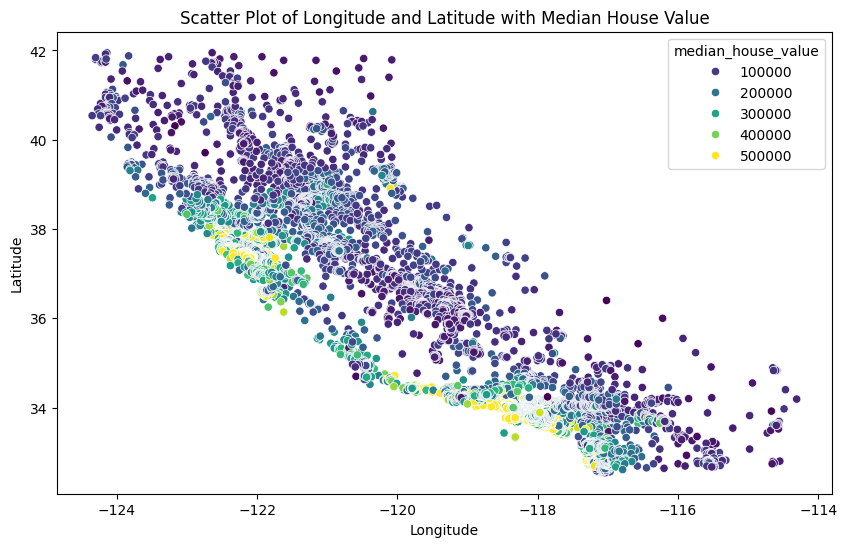

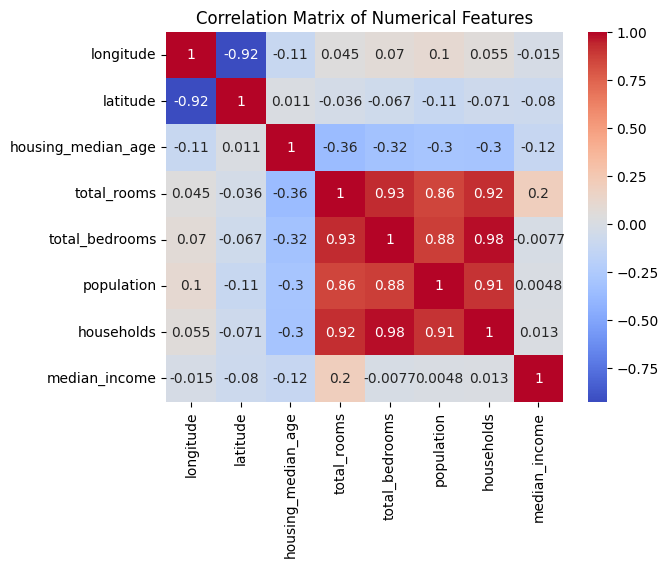

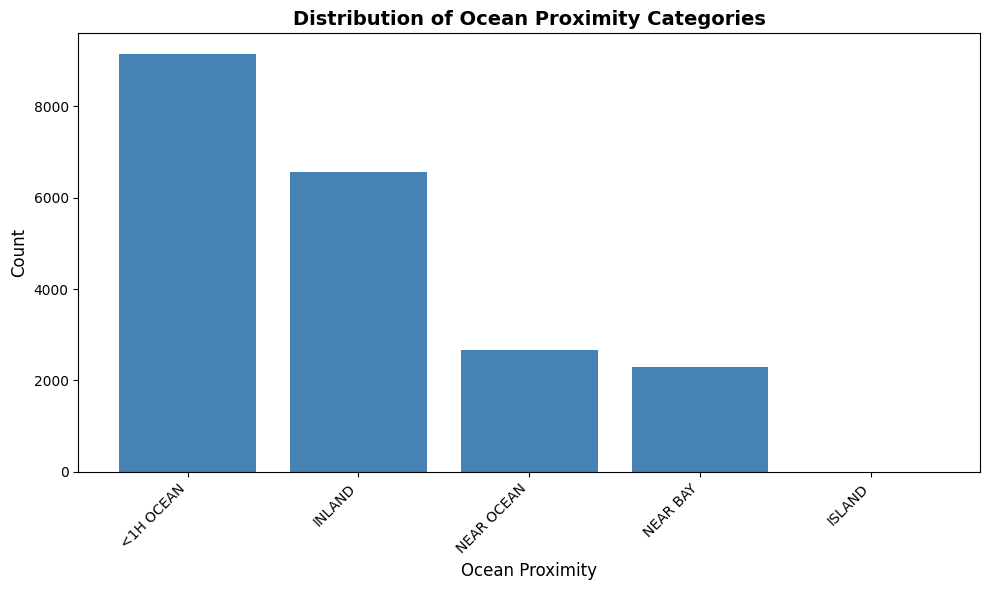

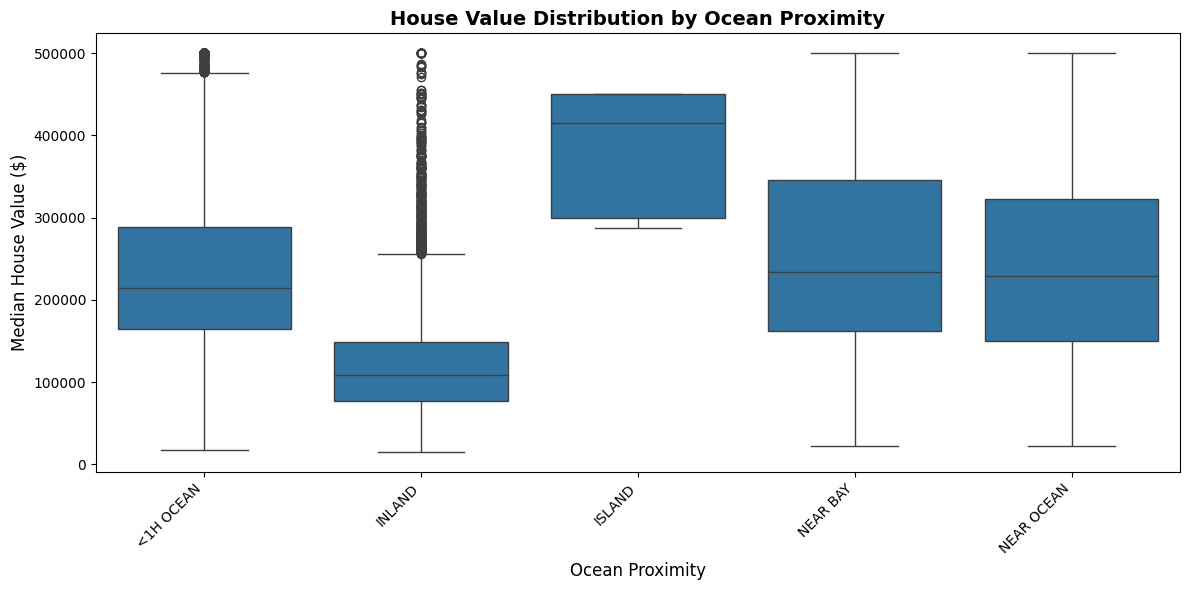

In [63]:
# plot the histogram of the numerical features (in 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.histplot(df[feature], bins=30, kde=False, ax=axes[row, col])
    axes[row, col].set_title(f'Histogram of {feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

# plot the scatter plot of longitude and latitude
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', data=df, hue='median_house_value', palette='viridis')
plt.title('Scatter Plot of Longitude and Latitude with Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# plot heatmap of the correlation matrix of the numerical features
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Ocean Proximity Distribution
plt.figure(figsize=(10, 6))
ocean_counts = df['ocean_proximity'].value_counts()
plt.bar(ocean_counts.index, ocean_counts.values, color='steelblue')
plt.title('Distribution of Ocean Proximity Categories', 
          fontsize=14, fontweight='bold')
plt.xlabel('Ocean Proximity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Box plots for median_house_value by ocean_proximity
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value')
plt.title('House Value Distribution by Ocean Proximity', 
          fontsize=14, fontweight='bold')
plt.xlabel('Ocean Proximity', fontsize=12)
plt.ylabel('Median House Value ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

In [64]:
# Split the data into training and testing sets
df_all_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_all_train, test_size=0.25, random_state=42)

y_train = df_train.median_house_value.values
y_all_train = df_all_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

df_train = df_train.drop('median_house_value', axis=1)
df_all_train = df_all_train.drop('median_house_value', axis=1)
df_val = df_val.drop('median_house_value', axis=1)
df_test = df_test.drop('median_house_value', axis=1)

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

all_train_dict = df_all_train.to_dict(orient='records')
X_all_train = dv.transform(all_train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test.to_dict(orient='records')
X_test = dv.transform(test_dict)

print(dv.get_feature_names_out())


['households' 'housing_median_age' 'latitude' 'longitude' 'median_income'
 'ocean_proximity=<1H OCEAN' 'ocean_proximity=INLAND'
 'ocean_proximity=ISLAND' 'ocean_proximity=NEAR BAY'
 'ocean_proximity=NEAR OCEAN' 'population' 'total_bedrooms' 'total_rooms']


## 4. Model Training and Evaluation

In [70]:
# 4. Model Training and Evaluation

# Train the model with Linear Regression (Baseline Model) 
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_val)
baseline_rmse = np.sqrt(mean_squared_error(y_val, baseline_predictions))
print(f"Baseline Model has RMSE: {baseline_rmse}")

# Train the model with Lasso Regression with hyperparameters tuning
lasso_alpha = [0.001, 0.01, 0.1, 1, 10, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 40, 50, 60, 70, 80, 90, 100, 1000]
lasso_rmse = []
for alpha in lasso_alpha:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    lasso_predictions = lasso_model.predict(X_val)
    lasso_rmse.append(np.sqrt(mean_squared_error(y_val, lasso_predictions)))
    print(f"Lasso Model with alpha={alpha} has RMSE: {lasso_rmse[-1]}")

# Train the model with Ridge Regression with hyperparameters tuning
ridge_alpha = [0.001, 0.01, 0.1, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]
ridge_rmse = []
for alpha in ridge_alpha:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    ridge_predictions = ridge_model.predict(X_val)
    ridge_rmse.append(np.sqrt(mean_squared_error(y_val, ridge_predictions)))
    print(f"Ridge Model with alpha={alpha} has RMSE: {ridge_rmse[-1]}")

# Best parameters
best_lasso_alpha = lasso_alpha[np.argmin(lasso_rmse)]
best_ridge_alpha = ridge_alpha[np.argmin(ridge_rmse)]
print(f"Best Lasso Alpha: {best_lasso_alpha}")
print(f"Best Ridge Alpha: {best_ridge_alpha}")

# Update the models with the best parameters
lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X_train, y_train)
ridge_model = Ridge(alpha=best_ridge_alpha)
ridge_model.fit(X_train, y_train)


Baseline Model has RMSE: 68645.27789950247


/Users/kelvinchan/Documents/Documents - Kelvin’s MacBook Air/dev/capstone-california-housing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.733e+12, tolerance: 1.640e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Model with alpha=0.001 has RMSE: 68645.27135501911


/Users/kelvinchan/Documents/Documents - Kelvin’s MacBook Air/dev/capstone-california-housing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.733e+12, tolerance: 1.640e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Model with alpha=0.01 has RMSE: 68645.21246684309


/Users/kelvinchan/Documents/Documents - Kelvin’s MacBook Air/dev/capstone-california-housing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.733e+12, tolerance: 1.640e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Model with alpha=0.1 has RMSE: 68644.62479011618


/Users/kelvinchan/Documents/Documents - Kelvin’s MacBook Air/dev/capstone-california-housing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.735e+12, tolerance: 1.640e+10
  model = cd_fast.enet_coordinate_descent(


Lasso Model with alpha=1 has RMSE: 68638.86853753706
Lasso Model with alpha=10 has RMSE: 68592.53922456806
Lasso Model with alpha=20 has RMSE: 68566.91403779974
Lasso Model with alpha=21 has RMSE: 68565.84420676871
Lasso Model with alpha=22 has RMSE: 68565.04585244364
Lasso Model with alpha=23 has RMSE: 68564.51898316373
Lasso Model with alpha=24 has RMSE: 68564.26360350887
Lasso Model with alpha=25 has RMSE: 68564.27971397627
Lasso Model with alpha=26 has RMSE: 68564.56730747993
Lasso Model with alpha=27 has RMSE: 68565.12636015922
Lasso Model with alpha=28 has RMSE: 68565.9556639188
Lasso Model with alpha=29 has RMSE: 68567.05834347983
Lasso Model with alpha=30 has RMSE: 68568.43224547412
Lasso Model with alpha=40 has RMSE: 68576.20116099357
Lasso Model with alpha=50 has RMSE: 68575.44180810268
Lasso Model with alpha=60 has RMSE: 68574.7294723443
Lasso Model with alpha=70 has RMSE: 68574.06416770343
Lasso Model with alpha=80 has RMSE: 68573.44590129697
Lasso Model with alpha=90 has R

Ridge(alpha=10)

In [71]:
# Train the model with Neural Network (Keras)

# Convert sparse matrices to dense arrays for Keras (keep original sparse matrices for scikit-learn)
from scipy.sparse import issparse
if issparse(X_train):
    X_train_dense = X_train.toarray()
    X_val_dense = X_val.toarray()
    X_test_dense = X_test.toarray()
else:
    X_train_dense = X_train
    X_val_dense = X_val
    X_test_dense = X_test

# Use gradient clipping to prevent NaN
optimizer = Adam(clipnorm=1.0)

model = Sequential()
model.add(Dense(64, input_dim=X_train_dense.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])
model.fit(X_train_dense, y_train, epochs=50, batch_size=32, validation_data=(X_val_dense, y_val))
test_results = model.evaluate(X_test_dense, y_test, verbose=0)
nn_predictions = model.predict(X_test_dense, verbose=0)
# Flatten predictions to 1D array
nn_predictions = nn_predictions.flatten()
# Check for NaN and calculate RMSE
if np.isnan(nn_predictions).any() or np.isnan(test_results).any():
    print("Warning: Model produced NaN. Using validation set for evaluation.")
    val_results = model.evaluate(X_val_dense, y_val, verbose=0)
    nn_predictions_val = model.predict(X_val_dense, verbose=0).flatten()
    nn_rmse = np.sqrt(mean_squared_error(y_val, nn_predictions_val))
    print(f"Neural Network Model Validation RMSE: {nn_rmse:.2f}")
else:
    nn_rmse = np.sqrt(mean_squared_error(y_test, nn_predictions))
    print(f"Neural Network Model Test RMSE: {nn_rmse:.2f}")


Epoch 1/50


/Users/kelvinchan/Documents/Documents - Kelvin’s MacBook Air/dev/capstone-california-housing/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 47164633088.0000 - root_mean_squared_error: 216705.2344 - val_loss: 27211450368.0000 - val_root_mean_squared_error: 164958.9375
Epoch 2/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 26725027840.0000 - root_mean_squared_error: 163437.8594 - val_loss: 26196332544.0000 - val_root_mean_squared_error: 161852.8125
Epoch 3/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24567515136.0000 - root_mean_squared_error: 156709.2188 - val_loss: 24252547072.0000 - val_root_mean_squared_error: 155732.2969
Epoch 4/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22769528832.0000 - root_mean_squared_error: 150827.8750 - val_loss: 21478000640.0000 - val_root_mean_squared_error: 146553.7500
Epoch 5/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 20121632768.0000 - root_mean_squared_error: 141748.1094 - val_loss: 17800556544.0000 - val_root_mean_squared_error: 133418.7188
Epoch 6/50
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - loss: 16619

## Visualize the Results

Text(0, 0.5, 'Predicted Values')

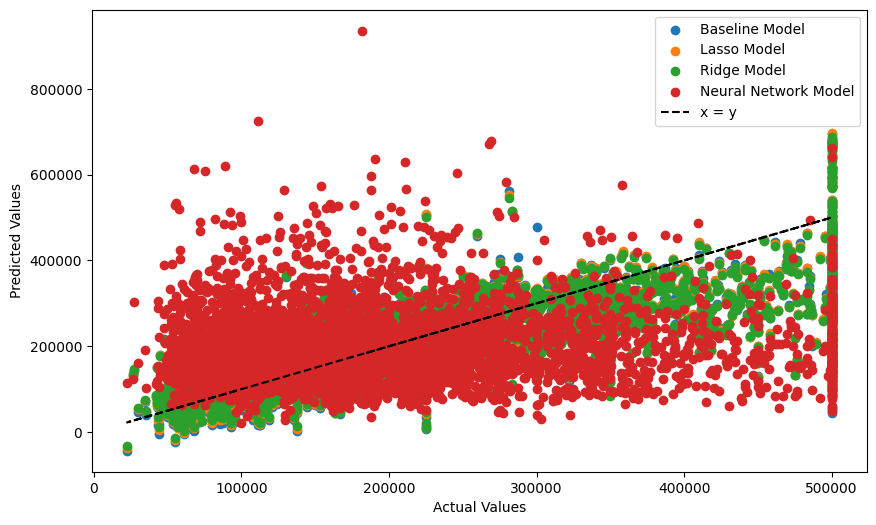

In [72]:
# Plot the predictions of each of the above models
plt.figure(figsize=(10, 6))
plt.scatter(y_val, baseline_predictions, label='Baseline Model')
plt.scatter(y_val, lasso_predictions, label='Lasso Model')
plt.scatter(y_val, ridge_predictions, label='Ridge Model')
plt.scatter(y_val, nn_predictions, label='Neural Network Model')
plt.plot(y_val, y_val, color='black', linestyle='--', label='x = y')
plt.legend()
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [75]:
# Test the models with the test set
baseline_predictions_test = baseline_model.predict(X_test)
lasso_predictions_test = lasso_model.predict(X_test)
ridge_predictions_test = ridge_model.predict(X_test)
nn_predictions_test = model.predict(X_test)

# Calculate the MSE of the test set
baseline_mse_test = mean_squared_error(y_test, baseline_predictions_test)
lasso_mse_test = mean_squared_error(y_test, lasso_predictions_test)
ridge_mse_test = mean_squared_error(y_test, ridge_predictions_test)
nn_mse_test = mean_squared_error(y_test, nn_predictions_test)

print(f"Baseline Model has MSE: {baseline_mse_test}")
print(f"Lasso Model has MSE: {lasso_mse_test}")
print(f"Ridge Model has MSE: {ridge_mse_test}")
print(f"Neural Network Model has MSE: {nn_mse_test}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Model Export and Scripting

In [ ]:
# Use pickle to export the models
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)